In [1]:
"""
this script contains functions to visualize the different attributes
Author: Nathan Greffe
"""
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from collections import OrderedDict
from matplotlib.lines import Line2D
import itertools

In [2]:
results = pd.read_csv('architectures.csv')
results = results[np.logical_not(results.acc3.isnull())]
results.reset_index(inplace=True)
results['time'] = results['time'] * 1000
results['error'] = 100*(1.0 - results[['acc1', 'acc2', 'acc3']].mean(axis=1))
results['error_std'] = 100*results[['acc1', 'acc2', 'acc3']].std(axis=1)
is_KD = results.file_name.apply(lambda x: "KD" in x)
results_KD = results[is_KD]
results_KD.reset_index(inplace=True)
results = results[np.logical_not(is_KD)]
results.reset_index(inplace=True)
results.head()

,level_0,index,file_name,arch,depth,width,other,se,acc1,acc2,acc3,time,error,error_std
0,0,0,squeezenext_d9_w48_cosine,squeezenext,9,48,NaN,NaN,0.9168,0.9184,0.9049,52.7,8.663333,0.737586
1,1,1,effnet_d12_w32_e4_cosine,effnet,12,32,4.0,NaN,0.9035,0.9080,0.9030,21.5,9.516667,0.275379
2,2,2,shufflenetv1_d9_w80_g2_cosine,shufflenetv1,9,80,2.0,NaN,0.9107,0.9057,0.9048,50.7,9.293333,0.317857
3,3,3,shufflenetv2_d12_w64_cosine,shufflenetv2,12,64,NaN,NaN,0.9238,0.9242,0.9230,44.1,7.633333,0.061101
4,4,4,shufflenetv2_d18_w80_cosine,shufflenetv2,18,80,NaN,NaN,0.9347,0.9373,0.9345,93.0,6.450000,0.156205


In [3]:
results_val = pd.read_csv('architectures_val.csv')
results_val['time'] = results_val['time'] * 1000
results_val['error'] = 100*(1.0 - results_val['acc'])
results_val.head()

,file_name,arch,depth,width,other,acc,time,error
0,effnet_d12_e2_cosine,effnet,12,2,NaN,0.8902,10.2,10.98
1,effnet_d12_e3_cosine,effnet,12,32,3.0,0.9038,15.3,9.62
2,effnet_d12_e4_cosine,effnet,12,32,4.0,0.9102,21.5,8.98
3,effnet_d15_e2_cosine,effnet,15,2,NaN,0.8888,10.1,11.12
4,effnet_d15_e3_cosine,effnet,15,32,3.0,0.8964,15.4,10.36


In [4]:
pruning_wrn_res = pd.read_csv('../NetAdapt/pruning_methods.csv')
pruning_wrn_res['table_time'] = pruning_wrn_res['table_time'] * 1000
pruning_wrn_res['measured_time'] = pruning_wrn_res['measured_time'] * 1000
pruning_wrn_res = pruning_wrn_res[np.logical_or(
    pruning_wrn_res.method == 'unpruned',
    np.logical_and(pruning_wrn_res.method == 'fisher_table', 
    pruning_wrn_res.criterion.isnull()))]  # we take the unpruned + fisher table WRNs
pruning_wrn_res.head()

,file_name,no_fine_tune,fine_tune,retrain_scratch,table_time,measured_time,method,criterion
39,res-40-2-table_fisher-pf=0.8-150ch,5.28,NaN,4.97,284.2,285.6,fisher_table,NaN
40,res-40-2-table_fisher-pf=0.8-300ch,5.39,NaN,5.25,243.1,240.4,fisher_table,NaN
41,res-40-2-table_fisher-pf=0.8-450ch,5.29,NaN,5.36,220.5,222.0,fisher_table,NaN
42,res-40-2-table_fisher-pf=0.8-600ch,7.52,NaN,5.71,168.6,166.8,fisher_table,NaN
43,res-40-2-table_fisher-pf=0.8-750ch,15.80,NaN,5.92,119.3,117.9,fisher_table,NaN


In [5]:
# fits a polynom
polynom = np.poly1d(np.polyfit(pruning_wrn_res.measured_time, 
                               pruning_wrn_res.retrain_scratch, 4))

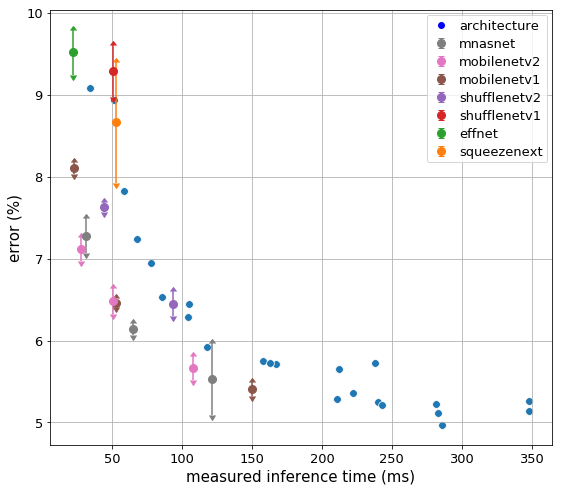

In [6]:
displays_SE = False
displays_WRN = False

_, idx = np.unique(results.arch, return_index=True)
color_labels = results.arch[np.sort(idx)]
rgb_values = sns.color_palette(n_colors=color_labels.shape[0]+1)[1:]  # skips blue which is 
# already used
color_map = dict(zip(color_labels, rgb_values))
colors = results.arch.map(color_map)

fig, ax = plt.subplots(1, figsize=(9, 8))
sns.scatterplot(x="measured_time", y="retrain_scratch", data=pruning_wrn_res, legend='brief', 
                ax=ax, s=60)
# plt.plot(np.arange(35,351,15), polynom(np.arange(35,351,15)))
for i in range(results.shape[0]):
    if (displays_SE or ('se' not in results.file_name[i])) and \
    (not displays_SE or results.arch[i] not in ['squeezenext', 'effnet', 'shufflenetv1']):  
        # do not displays SE when displays_SE == False and do not show bad arch. when SE == True
        plt.errorbar(results.time[i], 
                     results.error[i],
                     color=colors[i],
                     yerr=results.error_std[i],
                     fmt='x' if 'se' in results.file_name[i] else 'o', 
                     lolims=True, uplims=True,
                     markersize=8, 
                     alpha=.35 if displays_SE and 'se' not in results.file_name[i] else 1,
                     ecolor=colors[i],
                     label=results.arch[i])
ax.set_xlabel('measured inference time (ms)', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()  # removes duplicates

if displays_SE:
    by_label = OrderedDict(zip(labels, handles))
else:
    by_label = OrderedDict(zip(labels[::-1], handles[::-1])) # so as to have rounds or 
    # crosses in the legend

labels = [i for i in by_label.keys()]
handles = [i for i in by_label.values()]

if displays_SE:
    handles.append(Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='w', markersize=8))
    labels.append('')

    handles.append(Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='w', markersize=8))
    labels.append('SE block')

    handles.append(Line2D([0], [0], marker='o', color='w', label='with',
                              markerfacecolor='k', alpha=0.35, markersize=8))
    labels.append('without')

    handles.append(Line2D([0], [0], marker='X', color='w', label='retrain_scratch',
                              markerfacecolor='k', markersize=8))
    labels.append('with')
    
if displays_WRN:
    handles.append(Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='b', markersize=8))
    labels.append('WRN (fisher_table pruning)')
    
handles = [Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='b' , markersize=8)] + handles
labels = ['architecture'] + labels

ax.legend(handles, labels)
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.tick_params(axis='both', which='major', labelsize=13)  # for ticks
# plt.savefig(f'arch_comparison{"_SE" if displays_SE else "_WRN" if displays_WRN else ""}.pdf')

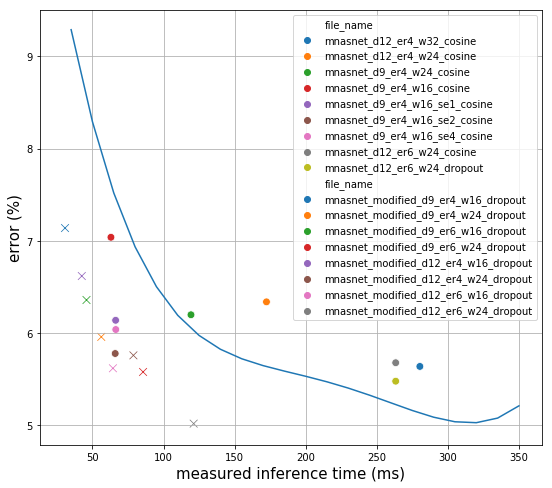

In [7]:
fig, ax = plt.subplots(1, figsize=(9, 8))
offset_modif = results_val[results_val.arch == "mnasnet"].apply(lambda x: 'modif' in x.file_name, axis=1)
results_val_to_plot = results_val[results_val.arch == "mnasnet"][np.logical_not(offset_modif)]
sns.scatterplot(x="time", y="error", data=results_val_to_plot, hue='file_name', 
                legend='brief', ax=ax, s=60, marker='o')
results_val_to_plot = results_val[results_val.arch == "mnasnet"][offset_modif]
sns.scatterplot(x="time", y="error", data=results_val_to_plot, hue='file_name', 
                legend='brief', ax=ax, s=60, marker='x')
plt.plot(np.arange(35,351,15), polynom(np.arange(35,351,15)))
ax.set_xlabel('measured inference time (ms)', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True)

In [22]:
def plot_matrix(matrix, std_matrix, x_values, y_values, x_label, y_label, z_label, cmap=plt.cm.Blues, 
                file_name=None):
    """
    plot the accuracies obtained by grid search in a readable way
    
    :param matrix: the matrix to plot
    :param std_matrix: the standard deviation of the matrix to plot
    :param x_values: the values of the parameter that evolved around the 2nd dimension (np array)
    :param y_values: the values of the parameter that evolved around the 1st dimension (np array)
    :param x_label: the name of the parameter that evolved around the 2nd dimension
    :param y_label: the name of the parameter that evolved around the 1st dimension
    :param z_label: the name of the parameter that evolved around the 3rd dimension
    :param cmap: the color map to use
    :param file_name: the name of the file to save the figure on
    """
    fig, ax = plt.subplots(1, figsize=(9, 8))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap, aspect='auto')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(z_label, rotation=-90, va="bottom", fontsize=15)
    plt.xticks(np.arange(x_values.shape[0]), x_values)
    plt.yticks(np.arange(y_values.shape[0]), y_values)

    thresh_up = matrix.min() + 5 * (matrix.max() - matrix.min()) / 6.
    thresh_down = matrix.min() + (matrix.max() - matrix.min()) / 6.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, f"{matrix[i, j]: .2f}±{std_matrix[i, j]: .2f}",
                 horizontalalignment="center",
                 color="white" if (matrix[i, j] > thresh_up or matrix[i, j] < thresh_down) else "black",
                 fontsize=14)

    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=14)  # for ticks
    plt.tight_layout()
    if file_name is not None:
        plt.savefig(file_name)

In [23]:
results_KD_noKD = results_KD.merge(results, on=["arch", "time"], suffixes=("_KD", "_noKD"))
results_KD_noKD["delta_error"] = results_KD_noKD.error_KD - results_KD_noKD.error_noKD
results_KD_noKD["delta_error_std"] = (results_KD_noKD.error_std_KD**2 + results_KD_noKD.error_std_noKD**2)**0.5
results_KD_noKD = results_KD_noKD.sort_values(["arch", "time"])
results_KD_noKD

,level_0_KD,index_KD,file_name_KD,arch,depth_KD,width_KD,other_KD,se_KD,acc1_KD,acc2_KD,...,width_noKD,other_noKD,se_noKD,acc1_noKD,acc2_noKD,acc3_noKD,error_noKD,error_std_noKD,delta_error,delta_error_std
2,33,33,mnasnet_d9_er4_w16_se2_dropout_KD_t2_l02,mnasnet,9,16,4.0,2.0,0.9281,0.9320,...,16,4.0,2.0,0.9287,0.9279,0.9307,7.090000,0.144222,-0.056667,0.251462
5,32,32,mnasnet_d12_er6_w16_se2_dropout_KD_t2_l02,mnasnet,12,16,6.0,2.0,0.9366,0.9397,...,16,6.0,2.0,0.9391,0.9403,0.9414,5.973333,0.115036,0.173333,0.204124
7,31,31,mnasnet_d12_er6_w24_se2_dropout_KD_t2_l02,mnasnet,12,24,6.0,2.0,0.9461,0.9469,...,24,6.0,2.0,0.9457,0.9471,0.9473,5.330000,0.087178,-0.006667,0.106458
1,25,25,mobilenetv1_d15_w32_se2_cosine_KD_t2_l02,mobilenetv1,15,32,NaN,2.0,0.9254,0.9296,...,32,NaN,2.0,0.9250,0.9264,0.9254,7.440000,0.072111,-0.096667,0.274651
4,26,26,mobilenetv1_d12_w64_se2_cosine_KD_t2_l02,mobilenetv1,12,64,NaN,2.0,0.9410,0.9406,...,64,NaN,2.0,0.9404,0.9393,0.9401,6.006667,0.056862,-0.173333,0.161761
8,27,27,mobilenetv1_d15_w100_se2_cosine_KD_t2_l02,mobilenetv1,15,80,NaN,2.0,0.9491,0.9492,...,80,NaN,2.0,0.9489,0.9475,0.9472,5.213333,0.090738,-0.130000,0.090921
0,30,30,mobilenetv2_d9_er4_w16_se2_dropout_KD_t2_l02,mobilenetv2,9,16,4.0,2.0,0.9290,0.9254,...,16,4.0,2.0,0.9295,0.9286,0.9302,7.056667,0.080208,0.126667,0.258586
3,29,29,mobilenetv2_d9_er4_w24_se2_dropout_KD_t2_l02,mobilenetv2,9,24,4.0,2.0,0.9401,0.9373,...,24,4.0,2.0,0.9398,0.9414,0.9394,5.980000,0.105830,0.210000,0.203961
6,28,28,mobilenetv2_d12_er6_w24_se2_dropout_KD_t2_l02,mobilenetv2,12,24,6.0,2.0,0.9434,0.9452,...,24,6.0,2.0,0.9456,0.9464,0.9460,5.400000,0.040000,0.053333,0.224796


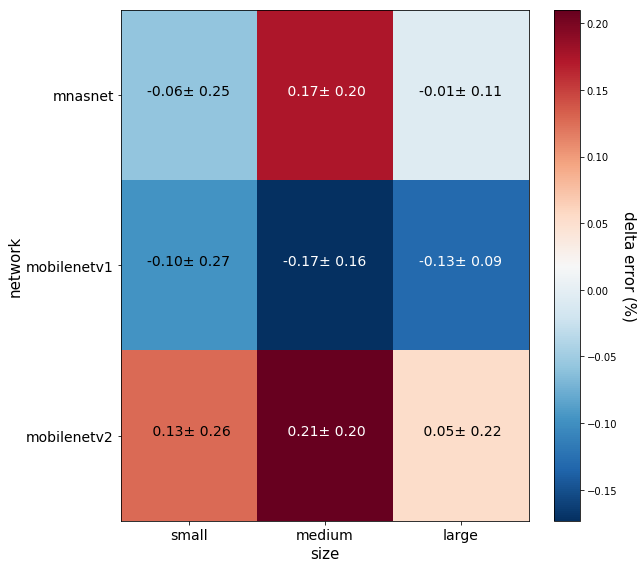

In [25]:
delta_error_mat = results_KD_noKD.delta_error.values.reshape([3, 3])
delta_error_std_mat = results_KD_noKD.delta_error_std.values.reshape([3, 3])
plot_matrix(delta_error_mat, delta_error_std_mat, 
            np.array(["small", "medium", "large"]), 
            results_KD_noKD.arch.values[0:-1:3],
            "size", "network", "delta error (%)", 
            cmap=plt.cm.RdBu_r)#, file_name='knowledge_distillation.pdf')

In [11]:
results_KD = results_KD.sort_values("time")
times = results_KD.time.tolist()
results_no_KD = results[results.time.apply(lambda x: x in times)].sort_values("time")

In [12]:
test_KD = pd.read_csv('test_KD.csv')
test_KD['error'] = 100*(1.0 - test_KD[['acc1', 'acc2', 'acc3']].mean(axis=1))
test_KD['error_std'] = 100*test_KD[['acc1', 'acc2', 'acc3']].std(axis=1)
test_KD.head()

,name,net,KD_pipeline,acc1,acc2,acc3,error,error_std
0,res-10-base,res-10,False,0.8928,0.8930,0.8925,10.723333,0.025166
1,res-22-base,res-22,True,0.9265,0.9264,0.9268,7.343333,0.020817
2,res-16-KD,res-16,True,0.9287,0.9226,0.9255,7.440000,0.305123
3,res-10-KD,res-10,True,0.9035,0.9003,0.9012,9.833333,0.165025


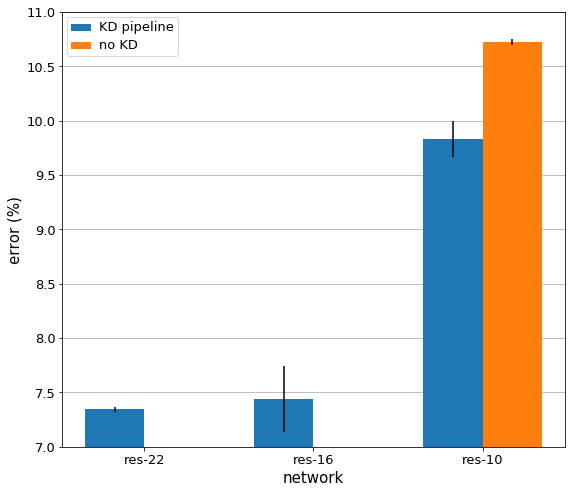

In [13]:
KD_pipeline = test_KD[test_KD.KD_pipeline].sort_values("net", ascending=False)
base_net = test_KD[np.logical_not(test_KD.KD_pipeline)]

N = KD_pipeline.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars


fig, ax = plt.subplots(1, figsize=(9, 8))
KD = ax.bar(ind, KD_pipeline.error, width, yerr=KD_pipeline.error_std)

no_KD = ax.bar(ind+width, [0, 0] + [base_net.error[0]], width, 
    yerr=[0, 0] + [base_net.error_std[0]])

# add some
ax.set_xlabel('network', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True, axis='y')
ax.set_ylim((7, 11))
ax.set_axisbelow(True)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(KD_pipeline.net)

ax.legend((KD[0], no_KD[0]), ('KD pipeline', 'no KD'))
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.tick_params(axis='both', which='major', labelsize=13)  # for ticks

# plt.savefig('KD_test.pdf')
plt.show()